In [18]:
import pymongo as pm #import MongoClient only
import ast
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import array
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
client = pm.MongoClient('bigdatadb.polito.it',
ssl=True,
authSource = 'carsharing',
username = 'ictts',
password ='Ict4SM22!',
tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_col = db['ictts_PermanentBookings'] # Collection for Car2go to use
Enjoy_Bookings_col = db['ictts_enjoy_PermanentBookings'] # Collection for Car2go to use

with open('data/IMQ/Zone/TorinoZonesArray.geojson') as file:
    lines = file.readlines()
    
zones = [ast.literal_eval(line)[0] for line in lines]

In [19]:
zones

[[[[[7.691863740888242, 45.070489011785504],
    [7.691502277482972, 45.069976267574496],
    [7.6931049096062, 45.06940050107999],
    [7.693700390732412, 45.06917326756794],
    [7.694659975840831, 45.068837671021356],
    [7.694171859859442, 45.068237969925804],
    [7.693838193427549, 45.06782907174575],
    [7.694954578554977, 45.06740524790493],
    [7.696057454235982, 45.06698125884916],
    [7.695274080838461, 45.06637819028057],
    [7.695994498714531, 45.065909322902876],
    [7.696972771397907, 45.06527235899328],
    [7.697718763756376, 45.06479477065485],
    [7.698691242087296, 45.065548507951455],
    [7.698832714004479, 45.065401589987836],
    [7.69906763599841, 45.06542227031892],
    [7.69906279469674, 45.065390708773954],
    [7.699042169545366, 45.06537247014065],
    [7.699030276281492, 45.06535433098812],
    [7.699003903269591, 45.06532702503567],
    [7.698980500877238, 45.06530875474862],
    [7.698934977255672, 45.06528573149588],
    [7.698894509930546, 45.0

In [20]:
Bookings_col.find_one()

{'_id': ObjectId('5a3bb3af20c3dd47cf59003d'),
 'init_fuel': 53,
 'vendor': 'car2go',
 'exterior': 'GOOD',
 'vin': 'WME4533421K152664',
 'final_address': 'Corso Regina Margherita, 107, 10122 Torino TO',
 'engineType': 'CE',
 'final_date': datetime.datetime(2017, 11, 1, 0, 19, 45),
 'public_transport': {'duration': -1,
  'arrival_time': -1,
  'distance': -1,
  'arrival_date': -1},
 'final_loc': {'coordinates': [7.68634, 45.07567], 'type': 'Point'},
 'smartPhoneRequired': True,
 'init_time': 1509490770,
 'interior': 'GOOD',
 'init_address': 'Lungo Dora Napoli, 18A, 10152 Torino TO',
 'init_loc': {'coordinates': [7.68486, 45.08276], 'type': 'Point'},
 'driving': {'duration': 234, 'distance': 966},
 'final_time': 1509491985,
 'plate': '288/FF214SJ',
 'city': 'Torino',
 'final_fuel': 53,
 'init_date': datetime.datetime(2017, 10, 31, 23, 59, 30),
 'walking': {'duration': 746, 'distance': 982}}

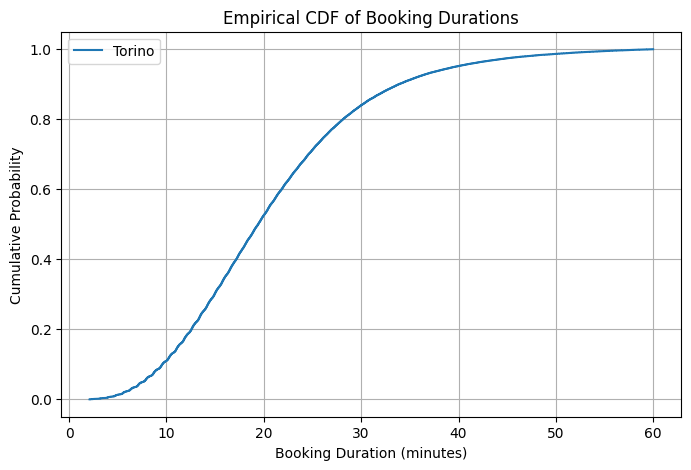

In [21]:
#Task 1: checking if data is already filtered
booking_duration = []
for doc in Bookings_col.find({"city": "Torino"}):
    booking_duration.append(doc["final_time"]- doc["init_time"])
    
booking_durations_np = np.array(booking_duration)/60
sorted_durations = np.sort(booking_durations_np)

cumulative_probabilities = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

plt.figure(figsize=(8, 5))
plt.plot(sorted_durations, cumulative_probabilities, label="Torino")


plt.xlabel("Booking Duration (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Booking Durations")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#Task 1: OD matrix of all bookings
od_matrix = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix[i, j] = 0



In [23]:
#od_amtrix enjoy
od_matrix_e = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Enjoy_Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_e[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_e[i, j] = 0



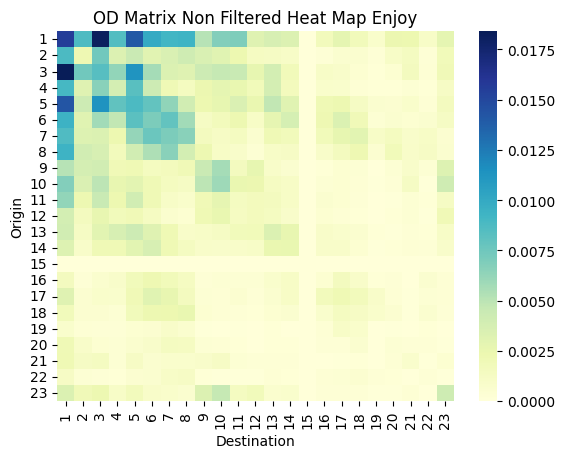

In [24]:
tot_sum = np.sum(od_matrix_e)
od_matrix_norm_e = od_matrix_e / tot_sum

plt.figure()
sns.heatmap(od_matrix_norm_e, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Non Filtered Heat Map Enjoy")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

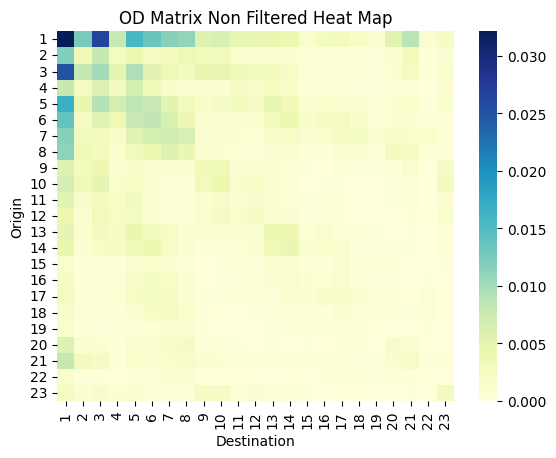

In [25]:
#Task 1: Heat map plot
tot_sum = np.sum(od_matrix)
od_matrix_norm = od_matrix / tot_sum

plt.figure()
sns.heatmap(od_matrix_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Non Filtered Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()


In [26]:
#Task 1a: filtering data by weekdays
od_matrix_weekdays = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekdays[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekdays[i, j] = 0

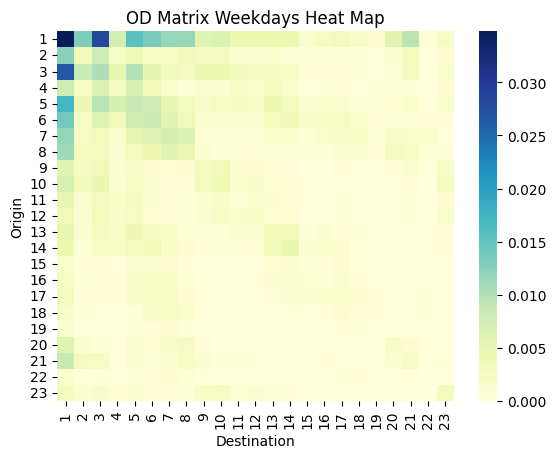

In [27]:
tot_sum = np.sum(od_matrix_weekdays)
od_matrix_weekdays_norm = od_matrix_weekdays / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekdays_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekdays Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [29]:
#Task 1a: filtering data by weekends
od_matrix_weekends = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$in": [1, 7]},
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekends[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekends[i, j] = 0

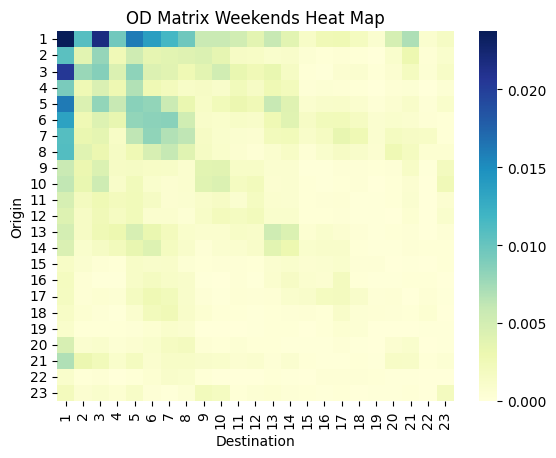

In [30]:
tot_sum = np.sum(od_matrix_weekends)
od_matrix_weekends_norm = od_matrix_weekends / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekends_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekends Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [31]:
pipeline = [
    {
        "$group": {
            "_id": None,
            "minDate": { "$min": "$init_date" }, 
            "maxDate": { "$max": "$init_date" }   
        }
    }
]

result = list(Enjoy_Bookings_col.aggregate(pipeline))

print("Start Date:", result[0]['minDate'])
print("End Date:", result[0]['maxDate'])


Start Date: 2017-09-01 00:03:29
End Date: 2017-10-31 23:58:50


In [32]:
#Task 1b: filter for just a week of data (week 36 of 2017) Start: Monday, September 4th, 2017
od_matrix_week36 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 36 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week36[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week36[i, j] = 0

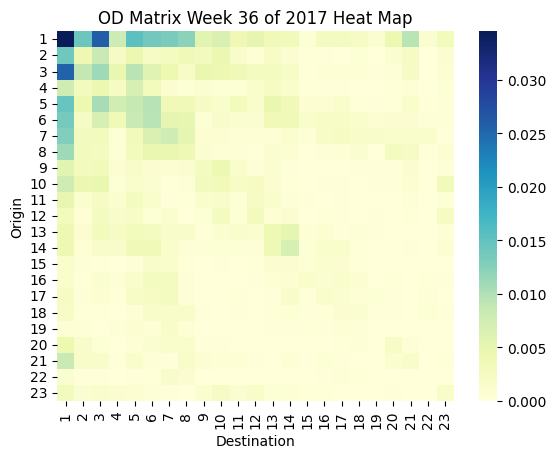

In [33]:
tot_sum = np.sum(od_matrix_week36)
od_matrix_week36_norm = od_matrix_week36 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week36_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 36 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [34]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39[i, j] = 0

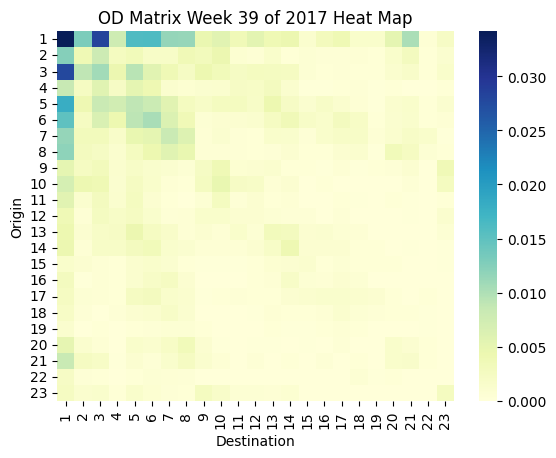

In [35]:
tot_sum = np.sum(od_matrix_week39)
od_matrix_week39_norm = od_matrix_week39 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [36]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39_enjoy = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Enjoy_Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39_enjoy[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39_enjoy[i, j] = 0

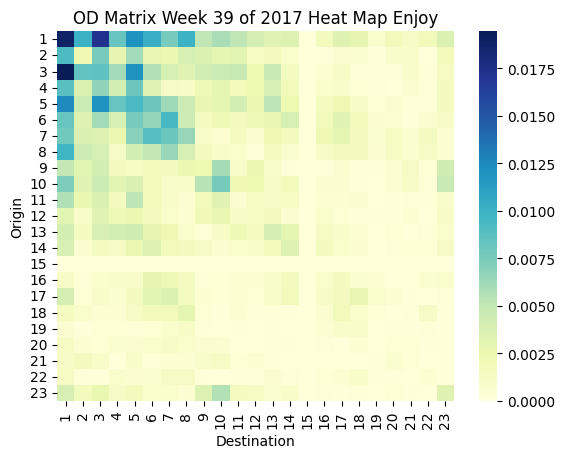

In [37]:
tot_sum = np.sum(od_matrix_week39_enjoy)
od_matrix_week39_enjoy_norm = od_matrix_week39_enjoy / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_enjoy_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map Enjoy")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [38]:
rand_matrix_A = np.random.rand(23, 23)
rand_matrix_A = rand_matrix_A / np.sum(rand_matrix_A)

rand_matrix_B = np.random.rand(23, 23)
rand_matrix_B = rand_matrix_B / np.sum(rand_matrix_B)

In [39]:
def simple_distance(matrix1, matrix2):
    return np.sum(np.abs(matrix1 - matrix2))

d1_rand = simple_distance(rand_matrix_A, rand_matrix_B)
print(f"Absolute distance between random matrixes: {d1_rand}")
d1_weeks = simple_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Absolute distance between week 36 and 39: {d1_weeks}")
d1_platfrom = simple_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Absolute distance between Car2go and Enjoy: {d1_platfrom}")

Absolute distance between random matrixes: 0.5809330793639115
Absolute distance between week 36 and 39: 0.22451423433648007
Absolute distance between Car2go and Enjoy: 0.40182221926214634


In [40]:
def euclidean_distance(matrix1, matrix2):
    return np.sqrt(np.sum((matrix1 - matrix2)**2))

d2_rand = euclidean_distance(rand_matrix_A, rand_matrix_B)
print(f"Euclidean distance between random matrixes: {d2_rand}")
d2_weeks = euclidean_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Euclidean distance between week 36 and 39: {d2_weeks}")
d2_platfrom = euclidean_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Euclidean distance between Car2go and Enjoy: {d2_platfrom}")

Euclidean distance between random matrixes: 0.03185043735218796
Euclidean distance between week 36 and 39: 0.014469360864313519
Euclidean distance between Car2go and Enjoy: 0.033929065764338504


In [41]:
def max_absolute_difference(A, B):
    absolute_diff = np.abs(A - B)
    return np.max(absolute_diff)

dMax_rand = max_absolute_difference(rand_matrix_A, rand_matrix_B)
print(f"Max absolute difference between random matrixes: {dMax_rand}")
dMax_weeks = max_absolute_difference(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max absolute difference between week 36 and 39: {dMax_weeks}")
dMax_platfrom = max_absolute_difference(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max absolute difference between Car2go and Enjoy: {dMax_platfrom}")

Max absolute difference between random matrixes: 0.0036787235968500894
Max absolute difference between week 36 and 39: 0.003416542416515265
Max absolute difference between Car2go and Enjoy: 0.015290397778564238


In [42]:
def compute_dm(A, B):
    M = A - B
    n = M.shape[0]  # Size of the matrix
    x = np.random.rand(n)  # Random vector
    x /= np.linalg.norm(x)  # Normalize it to have ||x|| = 1
    for _ in range(100):
        x = M.T @ (M @ x)  # Multiply by M.T @ M
        x /= np.linalg.norm(x)  # Normalize to ensure ||x|| = 1
    max_norm = np.linalg.norm(M @ x)
    return max_norm

dNorm_rand = compute_dm(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand}")
dNorm_weeks = compute_dm(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks}")
dNorm_platfrom = compute_dm(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom}")

Max norm of the difference between random matrixes: 0.01224249139220512
Max norm of the difference between week 36 and 39: 0.007273287611600089
Max norm of the difference between Car2go and Enjoy: 0.027162553790261276


In [43]:

def compute_dm2(A, B, iterations=100, tol=1e-9):
    # Step 1: Compute the difference matrix M = A - B
    M = A - B
    n = M.shape[0]  # Number of rows/columns (assuming square matrix)
    
    # Step 2: Start with a random vector x
    x = np.random.rand(n)
    x /= np.linalg.norm(x)  # Normalize x to have ||x|| = 1
    
    # Step 3: Perform power iteration
    prev_norm = 0
    for _ in range(iterations):
        # Multiply M by the current vector x
        x = M @ x
        
        # Compute the 2-norm of the resulting vector
        current_norm = np.linalg.norm(x)
        
        # Normalize x for the next iteration
        x /= current_norm
        
        # Check for convergence
        if abs(current_norm - prev_norm) < tol:
            break
        prev_norm = current_norm
    
    return current_norm

dNorm_rand2 = compute_dm2(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand2}")
dNorm_weeks2 = compute_dm2(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks2}")
dNorm_platfrom2 = compute_dm2(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom2}")

Max norm of the difference between random matrixes: 0.007544245411811463
Max norm of the difference between week 36 and 39: 0.0051457972961066025
Max norm of the difference between Car2go and Enjoy: 0.026708361552720303


In [44]:
#question 3


unipol_info = pd.read_csv('./data/Unipoldata/Info_TO.csv')
unipol_trips = pd.read_csv('./data/Unipoldata/Trips_OD_TO.csv')
imq_data = pd.read_csv('./data/IMQ/IMQData_Torino.csv')

unipol_data = pd.merge(unipol_trips, unipol_info, on='id_veicolo')

print("UnipolTech Data:")
print(unipol_data.head())
print("IMQ Data:")
print(imq_data.head())

UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  
0  2024-08-27 21:16:05    45.069     7.698           N          47      M  
1  2024-08-27 21:32:03    45.083     7.675           N          47      M  
2  2024-08-28 08:29:07    45.067     7.688           N          47      M  
3  2024-08-28 11:54:02    45.083     7.675           N          47      M  
4  2024-08-29 12:31:44    45.077     7.668           N          47      M  
IMQ Data:
    ID_INT  GENDER  AGE  MOTIVATION ORI_ZONE           DEP_HOUR DST_ZONE  \
0  81393

In [45]:
from shapely.geometry import Point, Polygon, mapping
import json


with open('./data/IMQ/Zone/TorinoZonescol.geojson') as file:
    data = json.load(file)

zones = []
for feature in data['features']:
    coordinates = feature['geometry']['coordinates']
    if feature['geometry']['type'] == 'Polygon':
        zones.append(Polygon(coordinates[0]))
    elif feature['geometry']['type'] == 'MultiPolygon':
        for polygon in coordinates:
            zones.append(Polygon(polygon[0]))


zone_gdf = gpd.GeoDataFrame(geometry=zones)


def find_zone(lat, lon):
    point = Point(lon, lat)
    for i, zone in enumerate(zones):
        if zone.contains(point):
            return i
    return -1

unipol_data['ORI_ZONE'] = unipol_data.apply(lambda row: find_zone(row['lat_start'], row['lon_start']), axis=1)
unipol_data['DST_ZONE'] = unipol_data.apply(lambda row: find_zone(row['lat_stop'], row['lon_stop']), axis=1)

unipol_data = unipol_data[(unipol_data['ORI_ZONE'] != -1) & (unipol_data['DST_ZONE'] != -1)]

imq_data['ORI_ZONE'] = imq_data['ORI_ZONE'].str.replace('Q', '').astype(int)
imq_data['DST_ZONE'] = imq_data['DST_ZONE'].str.replace('Q', '').astype(int)

imq_data = imq_data[(imq_data['ORI_ZONE'] != -1) & (imq_data['DST_ZONE'] != -1)]

Distance between normalized UnipolTech and IMQ OD matrices: 0.030030453082884857


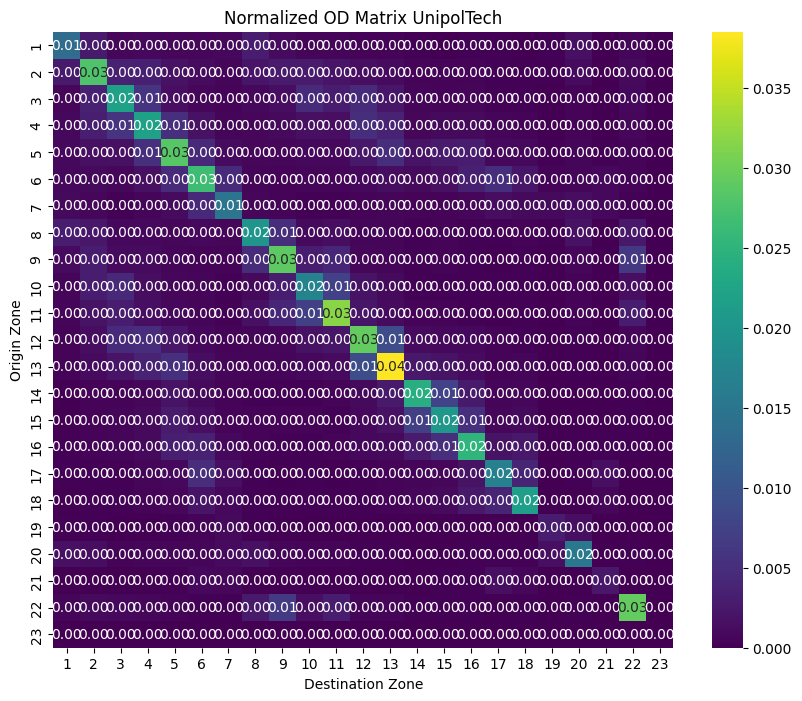

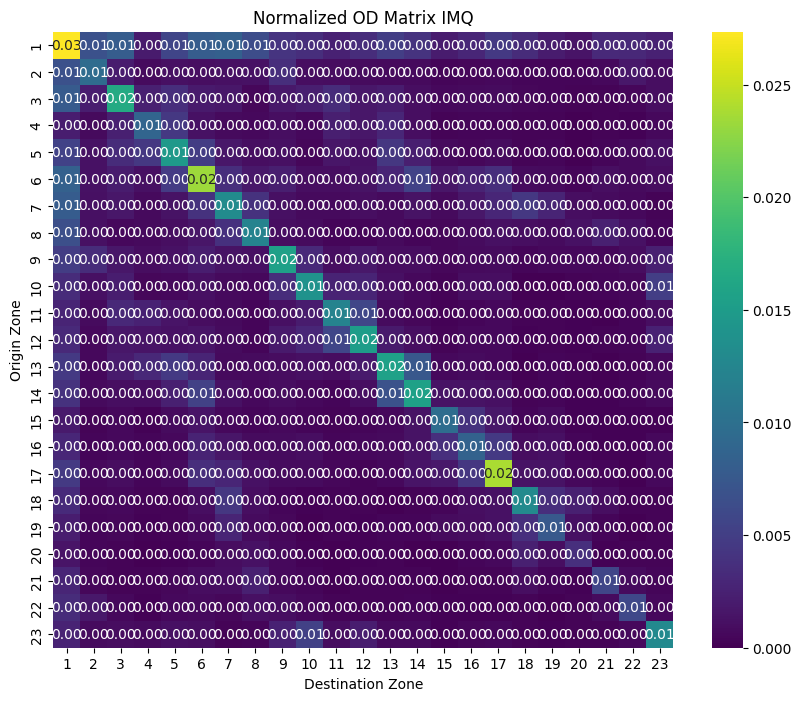

In [46]:
max_zone_index = 23
od_matrix_unipol = np.zeros((max_zone_index  , max_zone_index ), dtype=int)
od_matrix_imq = np.zeros((max_zone_index , max_zone_index ), dtype=int)

for _, row in unipol_data.iterrows():
    if 1 <= row['ORI_ZONE'] <= max_zone_index and 1 <= row['DST_ZONE'] <= max_zone_index:
        od_matrix_unipol[row['ORI_ZONE'] -1, row['DST_ZONE']-1 ] += 1

# Compute the OD matrix for IMQ
for _, row in imq_data.iterrows():
    if 1 <= row['ORI_ZONE'] <= max_zone_index and 1 <= row['DST_ZONE'] <= max_zone_index:
        od_matrix_imq[row['ORI_ZONE']-1 , row['DST_ZONE'] -1] += 1

od_matrix_unipol_normalized = od_matrix_unipol / od_matrix_unipol.sum()
od_matrix_imq_normalized = od_matrix_imq / od_matrix_imq.sum()

od_matrix_unipol_flat = od_matrix_unipol_normalized.flatten()
od_matrix_imq_flat = od_matrix_imq_normalized.flatten()

distance = compute_dm2(od_matrix_unipol_normalized, od_matrix_imq_normalized)
print(f"Distance between normalized UnipolTech and IMQ OD matrices: {distance}")


plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix_unipol_normalized, annot=True, fmt=".2f", cmap="viridis",xticklabels=range(1, 24), yticklabels=range(1, 24))
plt.title("Normalized OD Matrix UnipolTech")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")

plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix_imq_normalized, annot=True, fmt=".2f", cmap="viridis",xticklabels=range(1, 24), yticklabels=range(1, 24))
plt.title("Normalized OD Matrix IMQ")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")
plt.show()

In [47]:
#3a
unipol_groups = unipol_data.groupby(['genere', 'eta_approx', 'commerciale'])

imq_groups = imq_data.groupby(['GENDER', 'AGE'])

max_zone_index = 23
def compute_od_matrix(group, max_zone_index):
    od_matrix = np.zeros((max_zone_index , max_zone_index ), dtype=int)
    for _, row in group.iterrows():
        if row['ORI_ZONE'] <= max_zone_index and row['DST_ZONE'] <= max_zone_index:
            od_matrix[row['ORI_ZONE']-1, row['DST_ZONE']-1] += 1
    return od_matrix

unipol_od_matrices = {name: compute_od_matrix(group, max_zone_index) for name, group in unipol_groups}

imq_od_matrices = {name: compute_od_matrix(group, max_zone_index) for name, group in imq_groups}

def normalize_od_matrix(od_matrix):
    return od_matrix / od_matrix.sum()

unipol_od_matrices_normalized = {name: normalize_od_matrix(matrix) for name, matrix in unipol_od_matrices.items()}

imq_od_matrices_normalized = {name: normalize_od_matrix(matrix) for name, matrix in imq_od_matrices.items()}




similarities = {}
for unipol_name, unipol_matrix in unipol_od_matrices_normalized.items():
    for imq_name, imq_matrix in imq_od_matrices_normalized.items():
        similarity = compute_dm2(unipol_matrix, imq_matrix)
        similarities[(unipol_name, imq_name)] = similarity

for (unipol_name, imq_name), similarity in similarities.items():
    unipol_gender, unipol_age, unipol_commercial = unipol_name
    imq_gen, imq_age = imq_name
    print(f"Similarity between UnipolTech group (Gender: {unipol_gender}, Age: {unipol_age}, Commercial: {unipol_commercial}) "
          f"and IMQ group (Gender: {imq_gen}, age: {imq_age}): {similarity}")

Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 1): 0.1258812982675952
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 2): 0.12934706167436813
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 3): 0.13146032829507726
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 4): 0.12885481769387008
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 1): 0.1306981413846246
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 2): 0.12845809125412616
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 3): 0.13731841745719614
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 4): 0.141430044512

Selected UnipolTech Group: ('F', 47, 'N')
Selected IMQ Group: (1, 4)


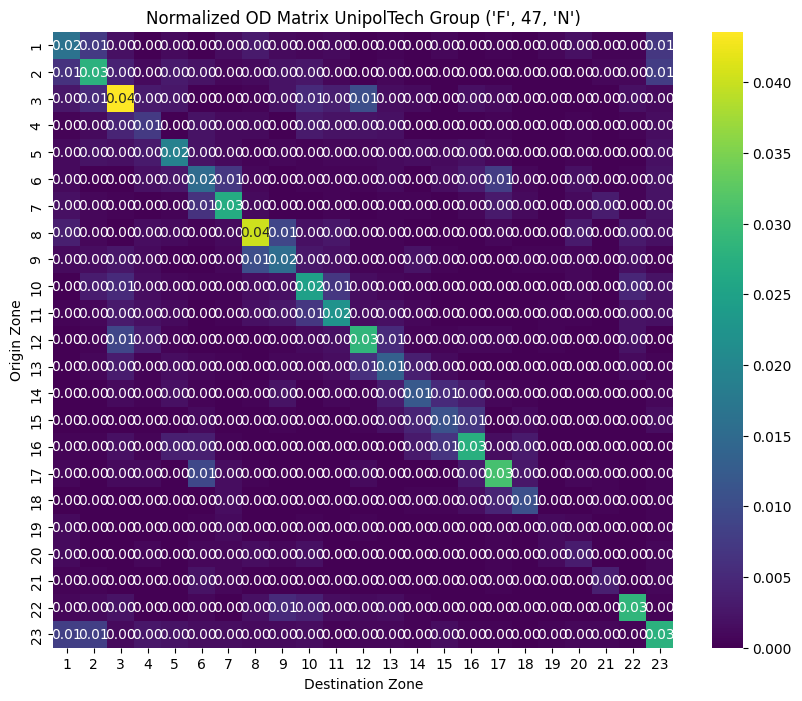

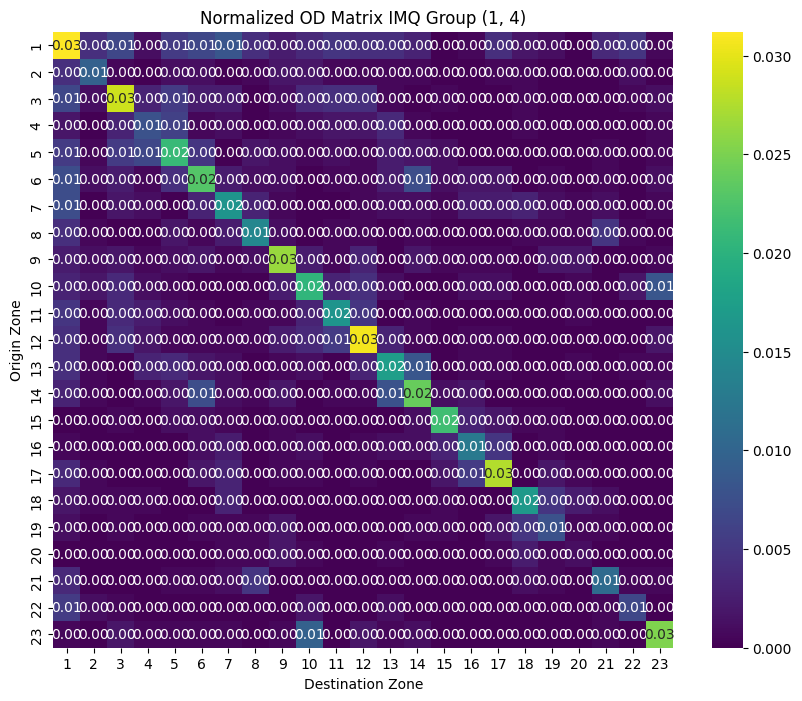

In [48]:
unipol_od_matrices_normalized = {
    (gender, int(age), commercial): matrix
    for (gender, age, commercial), matrix in unipol_od_matrices_normalized.items()
}

imq_od_matrices_normalized = {
    (int(gen), int(age)): matrix
    for (gen, age), matrix in imq_od_matrices_normalized.items()
}


selected_unipol_group = ('F', 47, 'N')  #gender, age , commercial
selected_imq_group = (1,4)  # gender - age

if selected_unipol_group not in unipol_od_matrices_normalized:
    print(f"UnipolTech group {selected_unipol_group} does not exist.")
else:
    print(f"Selected UnipolTech Group: {selected_unipol_group}")

if selected_imq_group not in imq_od_matrices_normalized:
    print(f"IMQ group {selected_imq_group} does not exist.")
else:
    print(f"Selected IMQ Group: {selected_imq_group}")

if selected_unipol_group in unipol_od_matrices_normalized:
    plt.figure(figsize=(10, 8))
    sns.heatmap(unipol_od_matrices_normalized[selected_unipol_group], annot=True, fmt=".2f", cmap="viridis", xticklabels=range(1, 24), yticklabels=range(1, 24))
    plt.title(f"Normalized OD Matrix UnipolTech Group {selected_unipol_group}")
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")

if selected_imq_group in imq_od_matrices_normalized:
    plt.figure(figsize=(10, 8))
    sns.heatmap(imq_od_matrices_normalized[selected_imq_group], annot=True, fmt=".2f", cmap="viridis", xticklabels=range(1, 24), yticklabels=range(1, 24))
    plt.title(f"Normalized OD Matrix IMQ Group {selected_imq_group}")
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")

plt.show()

In [49]:
gender_differences = {}
all_differences = {}
max_difference_age_groups = {}

for gender in imq_data['GENDER'].unique():
    age_groups = [key for key in imq_od_matrices_normalized.keys() if key[0] == gender]
    differences = []
    age_group_pairs = []
    for i in range(len(age_groups)):
        for j in range(i + 1, len(age_groups)):
            age_group1 = age_groups[i]
            age_group2 = age_groups[j]
            similarity = compute_dm2(imq_od_matrices_normalized[age_group1], imq_od_matrices_normalized[age_group2])
            differences.append(similarity)
            age_group_pairs.append((age_group1[1], age_group2[1]))
    all_differences[gender] = list(zip(age_group_pairs, differences))
    max_difference_index = np.argmax(differences)
    gender_differences[gender] = differences[max_difference_index]
    max_difference_age_groups[gender] = age_group_pairs[max_difference_index]


for gender, diffs in all_differences.items():
    print(f"Differences for gender {gender}:")
    for (age_group1, age_group2), difference in diffs:
        print(f"  Between ages {age_group1} and {age_group2}: {difference}")


for gender, difference in gender_differences.items():
    age_group1, age_group2 = max_difference_age_groups[gender]
    print(f"Maximum difference in behavior across age groups for gender {gender}: {difference} (between ages {age_group1} and {age_group2})")

max_difference_gender = max(gender_differences, key=gender_differences.get)
print(f"Gender with greater differences in behavior across age groups: {max_difference_gender}")

Differences for gender 1:
  Between ages 1 and 2: 0.020052612760011586
  Between ages 1 and 3: 0.02734102031572092
  Between ages 1 and 4: 0.02999618853822018
  Between ages 2 and 3: 0.01527414606976431
  Between ages 2 and 4: 0.025907882970828165
  Between ages 3 and 4: 0.025515848721194202
Differences for gender 2:
  Between ages 1 and 2: 0.033056671881099044
  Between ages 1 and 3: 0.03235135933623549
  Between ages 1 and 4: 0.0388900720966495
  Between ages 2 and 3: 0.014746303234793857
  Between ages 2 and 4: 0.028046713080596242
  Between ages 3 and 4: 0.020636913530603526
Maximum difference in behavior across age groups for gender 1: 0.02999618853822018 (between ages 1 and 4)
Maximum difference in behavior across age groups for gender 2: 0.0388900720966495 (between ages 1 and 4)
Gender with greater differences in behavior across age groups: 2


In [50]:
car2go_data = pd.DataFrame(list(Bookings_col.find()))
enjoy_data = pd.DataFrame(list(Enjoy_Bookings_col.find()))

with open('./data/IMQ/Zone/TorinoZonescol.geojson') as file:
    data = json.load(file)

zones = []
for feature in data['features']:
    coordinates = feature['geometry']['coordinates']
    if feature['geometry']['type'] == 'Polygon':
        zones.append(Polygon(coordinates[0]))
    elif feature['geometry']['type'] == 'MultiPolygon':
        for polygon in coordinates:
            zones.append(Polygon(polygon[0]))


zone_gdf = gpd.GeoDataFrame(geometry=zones)


def find_zone(lat, lon):
    point = Point(lon, lat)
    for i, zone in enumerate(zones):
        if zone.contains(point):
            return i
    return -1

def compute_od_matrix(group, max_zone_index):
    od_matrix = np.zeros((max_zone_index + 1, max_zone_index + 1), dtype=int)
    for _, row in group.iterrows():
        if row['origin'] <= max_zone_index and row['dest'] <= max_zone_index:
            od_matrix[row['origin'], row['dest']] += 1
    return od_matrix



car2go_od_matrix_normalized = normalize_od_matrix(od_matrix)
enjoy_od_matrix_normalized = normalize_od_matrix(od_matrix_e)

similarities = {}
for name, matrix in imq_od_matrices_normalized.items():
    car2go_similarity = compute_dm2(matrix, car2go_od_matrix_normalized)
    enjoy_similarity = compute_dm2(matrix, enjoy_od_matrix_normalized)
    similarities[name] = {'Car2GO': car2go_similarity, 'Enjoy': enjoy_similarity}

for name, sim in similarities.items():
    print(f"Similarity for group {name}: Car2GO = {sim['Car2GO']}, Enjoy = {sim['Enjoy']}")

max_car2go_similarity = min(similarities.items(), key=lambda x: x[1]['Car2GO'])
max_enjoy_similarity = min(similarities.items(), key=lambda x: x[1]['Enjoy'])

print(f"Maximum similarity for Car2GO: Group {max_car2go_similarity[0]} with similarity {max_car2go_similarity[1]['Car2GO']}")
print(f"Maximum similarity for Enjoy: Group {max_enjoy_similarity[0]} with similarity {max_enjoy_similarity[1]['Enjoy']}")

Similarity for group (1, 1): Car2GO = 0.04163615208728597, Enjoy = 0.030491998271412517
Similarity for group (1, 2): Car2GO = 0.036797240728780344, Enjoy = 0.025576317918904818
Similarity for group (1, 3): Car2GO = 0.030571431614497133, Enjoy = 0.02835203279533473
Similarity for group (1, 4): Car2GO = 0.03281803592547071, Enjoy = 0.03307808201824924
Similarity for group (2, 1): Car2GO = 0.043674016770599386, Enjoy = 0.03880273590325325
Similarity for group (2, 2): Car2GO = 0.032139319045149474, Enjoy = 0.030826966439247948
Similarity for group (2, 3): Car2GO = 0.035823867543995136, Enjoy = 0.029042056618256953
Similarity for group (2, 4): Car2GO = 0.039683003246251465, Enjoy = 0.041493460770371166
Maximum similarity for Car2GO: Group (1, 3) with similarity 0.030571431614497133
Maximum similarity for Enjoy: Group (1, 2) with similarity 0.025576317918904818


## Task 4
The idea is to use the KDE and estimate the 20 points of the city of Turin with highest densityof trips as hospot and then use Voronoi clustering to create zones around them

In [51]:
import pymongo as pm
import ast
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

client = pm.MongoClient(
    'bigdatadb.polito.it',
    ssl=True,
    authSource='carsharing',
    username='ictts',
    password='Ict4SM22!',
    tlsAllowInvalidCertificates=True
)


db = client['carsharing']
car2go_col = db['ictts_PermanentBookings']
enjoy_col = db['ictts_enjoy_PermanentBookings']

# Load CarSharing Trips
def load_trips(collection):
    return [
        {"latitude": doc["init_loc"]["coordinates"][1], "longitude": doc["init_loc"]["coordinates"][0]}
        for doc in collection.find({"city": "Torino"}) if 'init_time' in doc and 'final_time' in doc
        
    
    ]

car2go_trips = load_trips(car2go_col)
enjoy_trips = load_trips(enjoy_col)
unipol_df = pd.read_csv("data/Unipoldata/Trips_OD_TO.csv")


unipol_trips = [
    {"latitude": row["lat_start"], "longitude": row["lon_start"]}
    for _, row in unipol_df.iterrows()
]

trips_data = pd.DataFrame(car2go_trips + enjoy_trips)
trips_gdf = gpd.GeoDataFrame(
    trips_data, geometry=gpd.points_from_xy(trips_data["longitude"], trips_data["latitude"])
)
trips_gdf.crs = "EPSG:4326"

trips_gdf.to_file("Turin_trips.geojson", driver="GeoJSON")


In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import contextily as ctx

def find_high_density_hotspots(trips_gdf, kde_bandwidth=0.05, num_hotspots=20):
    trip_coords = np.array([[p.x, p.y] for p in trips_gdf.geometry])  # (lon, lat)
    kde = gaussian_kde(trip_coords.T, bw_method=kde_bandwidth)  # Perform KDE
    hotspot_scores = kde(trip_coords.T)
    hotspot_indices = np.argsort(hotspot_scores)[-num_hotspots:]  # Top hotspots
    hotspots = trips_gdf.iloc[hotspot_indices]
    return hotspots


key_locations_test = find_high_density_hotspots(trips_gdf)

fig, ax = plt.subplots(figsize=(10, 10))
trips_gdf.plot(
   color='blue',  
   markersize=3,
   ax=ax,
   legend=True,
    alpha=0.7,
    label='Trips'
)

key_locations_test.plot(
    color='maroon', 
    markersize=20,
    ax=ax,
    legend=True,
    alpha=0.7,
    label='Hotspots'
)

ctx.add_basemap(ax,zoom = 14, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("High Density Hotspots")
plt.savefig("High Density Hotspots2.png", dpi=300)
plt.legend()
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.spatial import Voronoi, voronoi_plot_2d


def voronoi_to_geodataframe(vor, bounds_polygon):
    regions = []
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if -1 not in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            polygon = polygon.intersection(bounds_polygon)
            if not polygon.is_empty:
                regions.append(polygon)
    return gpd.GeoDataFrame(geometry=regions, crs="EPSG:3857")


trip_coords = np.array([[p.x, p.y] for p in trips_gdf.geometry])

# K-Means clustering
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(trip_coords)
cluster_centers = kmeans.cluster_centers_

# Bounding box for the Voronoi Tessellation
bounds = trips_gdf.total_bounds
bounds_polygon = Polygon([
    (bounds[0], bounds[1]), (bounds[0], bounds[3]),
    (bounds[2], bounds[3]), (bounds[2], bounds[1]), (bounds[0], bounds[1])
])

# Creazione della Voronoi Tessellation
vor = Voronoi(cluster_centers)
voronoi_gdf = voronoi_to_geodataframe(vor, bounds_polygon)

# Creazione GeoDataFrame per i centri dei cluster
centers_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cluster_centers[:, 0], cluster_centers[:, 1]), crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 10))

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='lightblue', line_alpha=0.5, point_size=0)

centers_gdf.plot(ax=ax, color="red", markersize=50, label="Cluster Centers")

#trips_gdf.plot(ax=ax, color="gray", markersize=1, alpha=0.3, label="Trips")
ctx.add_basemap(ax, crs=trips_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)


ax.set_title("Voronoi Tessellation Based on K-Means Cluster Centers", fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig("K-Means_clustering.png", dpi=300)
plt.show()


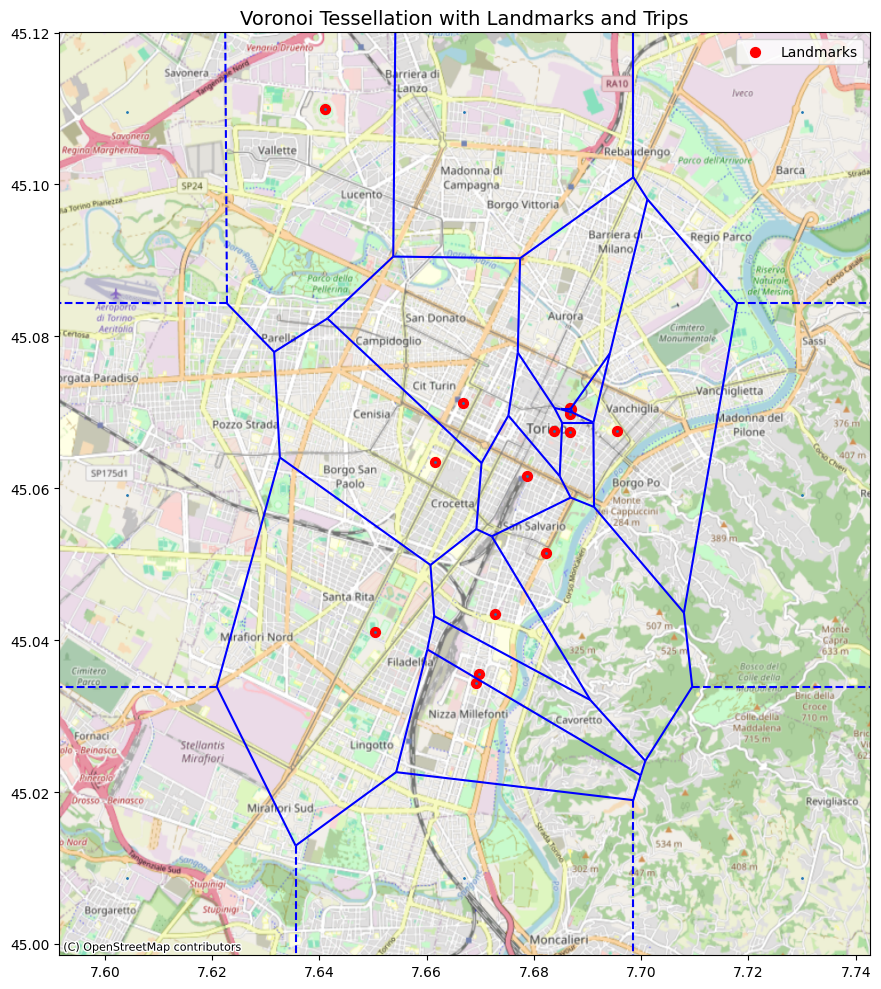

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Definizione dei landmarks con coordinate geografiche (lat, lon)
landmarks = [
    {"name": "Piazza Castello", "lon": 7.6868, "lat": 45.0705},
    {"name": "Mole Antonelliana", "lon": 7.6869, "lat": 45.0704},
    {"name": "Piazza San Carlo", "lon": 7.6837, "lat": 45.0676},
    {"name": "Stazione Porta Nuova", "lon": 7.6787, "lat": 45.0616},
    {"name": "Stazione Porta Susa", "lon": 7.6667, "lat": 45.0712},
    {"name": "Politecnico di Torino", "lon": 7.6616, "lat": 45.0635},
    {"name": "Università degli Studi di Torino", "lon": 7.6867, "lat": 45.0674},
    {"name": "Piazza Vittorio Veneto", "lon": 7.6955, "lat": 45.0675},
    {"name": "Parco del Valentino", "lon": 7.6822, "lat": 45.0515},
    {"name": "Lingotto Fiere", "lon": 7.6697, "lat": 45.0355},
    {"name": "Juventus Stadium", "lon": 7.6410, "lat": 45.1099},
    {"name": "Palazzo Madama", "lon": 7.6868, "lat": 45.0703},
    {"name": "Museo Egizio", "lon": 7.6867, "lat": 45.0698},
    {"name": "Ospedale Molinette", "lon": 7.6727, "lat": 45.0434},
    {"name": "Stadio Olimpico Grande Torino", "lon": 7.6503, "lat": 45.0411},
    {"name": "Lingotto (ex Fiat Factory)", "lon": 7.6692, "lat": 45.0343},
]


landmarks_df = pd.DataFrame(landmarks)
landmarks_gdf = gpd.GeoDataFrame(
    landmarks_df, geometry=gpd.points_from_xy(landmarks_df["lon"], landmarks_df["lat"])
)
landmarks_gdf.crs = "EPSG:4326"

def voronoi_to_geodataframe(vor, bounds_polygon):
    regions = []
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if -1 not in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            polygon = polygon.intersection(bounds_polygon)
            if not polygon.is_empty:
                regions.append(polygon)
    return gpd.GeoDataFrame(geometry=regions, crs="EPSG:4326")

def add_boundary_points(coords, bounds):
    """
    Aggiunge punti fittizi ai bordi del bounding box.
    """
    x_min, y_min, x_max, y_max = bounds
    boundary_points = [
        [x_min, y_min], [x_min, y_max], [x_max, y_min], [x_max, y_max],
        [(x_min + x_max) / 2, y_min], [(x_min + x_max) / 2, y_max], [x_min, (y_min + y_max) / 2], [x_max, (y_min + y_max) / 2]
    ]
    return np.vstack([coords, boundary_points])

coords = np.array([[p.x, p.y] for p in landmarks_gdf.geometry])
bounds = trips_gdf.total_bounds
bounds_polygon = Polygon([
    (bounds[0], bounds[1]), (bounds[0], bounds[3]),
    (bounds[2], bounds[3]), (bounds[2], bounds[1]), (bounds[0], bounds[1])
])
coords_with_boundary = add_boundary_points(coords, bounds)
vor = Voronoi(coords_with_boundary)
voronoi_gdf = voronoi_to_geodataframe(vor, bounds_polygon)

trips_gdf.crs = "EPSG:4326"
fig, ax = plt.subplots(figsize=(12, 10))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue',line_width = 1.5, point_size=2)

landmarks_gdf.plot(ax=ax, color="red", markersize=50, label="Landmarks")
ctx.add_basemap(ax, crs=landmarks_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Voronoi Tessellation with Landmarks and Trips", fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig("Voronoi_with_Landmarks2.png", dpi=300)
plt.show()


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


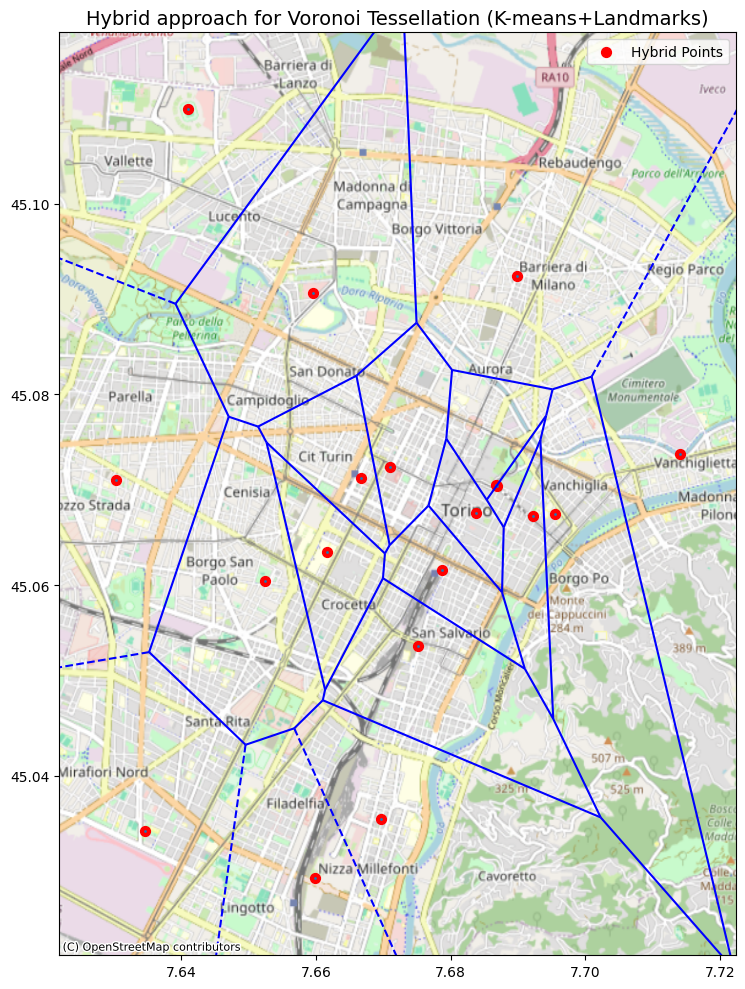

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import contextily as ctx

landmarks = [
    {"name": "Piazza Castello", "lon": 7.6868, "lat": 45.0705},
    {"name": "Mole Antonelliana", "lon": 7.6869, "lat": 45.0704},
    {"name": "Piazza San Carlo", "lon": 7.6837, "lat": 45.0676},
    {"name": "Stazione Porta Nuova", "lon": 7.6787, "lat": 45.0616},
    {"name": "Stazione Porta Susa", "lon": 7.6667, "lat": 45.0712},
    {"name": "Politecnico di Torino", "lon": 7.6616, "lat": 45.0635},
    {"name": "Piazza Vittorio Veneto", "lon": 7.6955, "lat": 45.0675},
    {"name": "Juventus Stadium", "lon": 7.6410, "lat": 45.1099},
    {"name": "Lingotto Fiere", "lon": 7.6697, "lat": 45.0355},
]

landmarks_df = pd.DataFrame(landmarks)
landmarks_gdf = gpd.GeoDataFrame(
    landmarks_df, geometry=gpd.points_from_xy(landmarks_df["lon"], landmarks_df["lat"])
)
landmarks_gdf.crs = "EPSG:4326"
trips_gdf.crs = "EPSG:4326"
trip_coords = np.array([[p.x, p.y] for p in trips_gdf.geometry])
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(trip_coords)
cluster_centers = kmeans.cluster_centers_
hybrid_coords = np.vstack([cluster_centers, [[p.x, p.y] for p in landmarks_gdf.geometry]])
vor = Voronoi(hybrid_coords)
def voronoi_to_geodataframe(vor, bounds_polygon):
    """
    Converte una Voronoi tessellation in un GeoDataFrame ritagliato sulla bounding box.
    """
    regions = []
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if -1 not in region and len(region) > 0:
            # Crea il poligono dalla regione
            polygon = Polygon([vor.vertices[i] for i in region])
            # Ritaglia il poligono alla bounding box
            polygon = polygon.intersection(bounds_polygon)
            if not polygon.is_empty:
                regions.append(polygon)
    return gpd.GeoDataFrame(geometry=regions, crs="EPSG:4326")

bounds = trips_gdf.total_bounds
bounds_polygon = Polygon([
    (bounds[0], bounds[1]), (bounds[0], bounds[3]),
    (bounds[2], bounds[3]), (bounds[2], bounds[1]), (bounds[0], bounds[1])
])

voronoi_gdf = voronoi_to_geodataframe(vor, bounds_polygon)

hybrid_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(hybrid_coords[:, 0], hybrid_coords[:, 1]), crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 10))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue',line_width = 1.5, point_size=2)
hybrid_gdf.plot(ax=ax, color="red", markersize=50, label="Hybrid Points")
ctx.add_basemap(ax, crs=landmarks_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Hybrid approach for Voronoi Tessellation (K-means+Landmarks)", fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig("Precise_Voronoi.png")
plt.show()


## Task 5
The idea is to compute the KDE for both dataset and then use Correlation and MSE to compare them

In [ ]:
import folium
from folium.plugins import HeatMap
import numpy as np
def load_destinations(collection):
    return [
        {"latitude": doc["final_loc"]["coordinates"][1], "longitude": doc["final_loc"]["coordinates"][0]}
        for doc in collection.find({"city": "Torino"}) if 'init_time' in doc and 'final_time' in doc
    
    ]

carsharing_origins = trips_gdf  
carsharing_destinations = load_destinations(car2go_col) + load_destinations(enjoy_col)
carsharing_destinations_gdf = gpd.GeoDataFrame(trips_data, geometry=gpd.points_from_xy(trips_data["longitude"], trips_data["latitude"])
)

unipol_origins = gpd.GeoDataFrame(
    unipol_df, geometry=gpd.points_from_xy(unipol_df["lon_start"], unipol_df["lat_start"]), crs="EPSG:4326"
)

unipol_destinations = gpd.GeoDataFrame(
    unipol_df, geometry=gpd.points_from_xy(unipol_df["lon_stop"], unipol_df["lat_stop"]), crs="EPSG:4326"
)

def kde_to_heatmap_data_limited(gdf, bounds, grid_size=100, bandwidth=0.01):
    coords = np.vstack([gdf.geometry.y, gdf.geometry.x])  # Folium usa lat, lon
    kde = gaussian_kde(coords, bw_method=bandwidth)

    
    x_min, y_min, x_max, y_max = bounds
    x, y = np.mgrid[y_min:y_max:grid_size*1j, x_min:x_max:grid_size*1j]
    grid_coords = np.vstack([x.ravel(), y.ravel()])
    density = kde(grid_coords).reshape(x.shape)

    
    heatmap_data = []
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            heatmap_data.append([x[i, j], y[i, j], density[i, j]])
    return heatmap_data

def plot_folium_heatmap(heatmap_data):
    m = folium.Map(location=[45.0703, 7.6869], zoom_start=12)

   
    HeatMap(
        heatmap_data,
        radius=12,       
        blur=18,         
        max_zoom=1,      
    ).add_to(m)

    return m

local_bounds = carsharing_origins.total_bounds 


carsharing_heatmap_data = kde_to_heatmap_data_limited(carsharing_origins, local_bounds)
carsharing_destinations_heatmap_data = kde_to_heatmap_data_limited(carsharing_destinations_gdf, local_bounds)
unipol_gen_heatmap_data = kde_to_heatmap_data_limited(unipol_origins, local_bounds)
unipol_dist_heatmap_data = kde_to_heatmap_data_limited(unipol_destinations, local_bounds)

# Plot delle heatmap con Folium
carsharing_map = plot_folium_heatmap(carsharing_heatmap_data)
carsharing_distributions_map = plot_folium_heatmap(carsharing_destinations_heatmap_data)
unipol_gen_map = plot_folium_heatmap(unipol_gen_heatmap_data)
unipol_dist_map = plot_folium_heatmap(unipol_dist_heatmap_data)


carsharing_map.save("carsharing_trip_generation_limited.html")
carsharing_distributions_map.save("carsharing_trip_distribution_limited.html")
unipol_gen_map.save("unipoltech_trip_generation_limited.html")
unipol_dist_map.save("unipoltech_trip_distribution_limited.html")


In [17]:
import folium
from folium.plugins import HeatMap
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error

# Function to compute KDE heatmap data and return flattened density grid
def kde_to_density_grid(gdf, bounds, grid_size=100, bandwidth=0.01):
    coords = np.vstack([gdf.geometry.y, gdf.geometry.x])  # Folium uses lat, lon
    kde = gaussian_kde(coords, bw_method=bandwidth)

    # Create grid
    x_min, y_min, x_max, y_max = bounds
    x, y = np.mgrid[y_min:y_max:grid_size*1j, x_min:x_max:grid_size*1j]
    grid_coords = np.vstack([x.ravel(), y.ravel()])
    density = kde(grid_coords).reshape(x.shape)
    return density, x, y

# Function to flatten the density grid for comparison
def flatten_density(density):
    return density.ravel()

# Function to compare densities using Correlation and MSE
def compare_densities(density1, density2, label1, label2):
    density1_flat = flatten_density(density1)
    density2_flat = flatten_density(density2)
    correlation = np.corrcoef(density1_flat, density2_flat)[0, 1]
    mse = mean_squared_error(density1_flat, density2_flat)
    print(f"{label1} vs {label2} - Correlation: {correlation:.4f}, MSE: {mse:.4f}")
    return correlation, mse

# Generate KDE density grids
local_bounds = carsharing_origins.total_bounds

carsharing_gen_density, x1, y1 = kde_to_density_grid(carsharing_origins, local_bounds)
carsharing_dist_density, x2, y2 = kde_to_density_grid(carsharing_destinations_gdf, local_bounds)
unipol_gen_density, x3, y3 = kde_to_density_grid(unipol_origins, local_bounds)
unipol_dist_density, x4, y4 = kde_to_density_grid(unipol_destinations, local_bounds)

# Compare densities
print("=== Density Comparisons ===")
compare_densities(carsharing_gen_density, unipol_gen_density, "CarSharing Generation", "UnipolTech Generation")
compare_densities(carsharing_dist_density, unipol_dist_density, "CarSharing Distribution", "UnipolTech Distribution")
compare_densities(unipol_gen_density, unipol_dist_density, "UnipolTech Generation", "UnipolTech Distribution")


=== Density Comparisons ===
CarSharing Generation vs UnipolTech Generation - Correlation: 0.3713, MSE: 34572.2813
CarSharing Distribution vs UnipolTech Distribution - Correlation: 0.3699, MSE: 34657.4309
UnipolTech Generation vs UnipolTech Distribution - Correlation: 0.9941, MSE: 94.0548


(0.9941293983391427, 94.05479573071877)